<a href="https://colab.research.google.com/github/gourav10/Monocular_Depth_Estimation/blob/main/Monocular_Depth_Estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import sys
from urllib.request import FancyURLopener
import shutil
from PIL import Image
import numpy as np
import scipy.ndimage
import scipy.io as sio
import h5py

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pprint

In [ ]:
def download(url, destination, tmp_dir='/tmp'):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\rDownloading %s %.1f%%' % (url,
          float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    urlretrieve = FancyURLopener().retrieve
    if url.endswith('.zip'):
        local_zip_path = os.path.join(tmp_dir, 'datasets_download.zip')
        urlretrieve(url, local_zip_path, _progress)
        with zipfile.ZipFile(local_zip_path, "r") as zip_ref:
          zip_ref.extractall('/content/nyu_depth_v2/temp')
        os.remove(local_zip_path)
    else:
        urlretrieve(url, destination, _progress)

In [ ]:
def dataset_download(url, destination):
    if not os.path.isfile(destination):
        download(url, destination)

In [ ]:
NYUD_URL = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
NYUD_SPLITS_URL = 'http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat'

In [ ]:
def save_nyu_depth_v2_dataset(source_dir, target_dir):
    if not os.path.isdir(source_dir):
        os.makedirs(source_dir)
    nyud_file_path = os.path.join(source_dir, 'nyu_depth_v2_labeled.mat')
    splits_file_path = os.path.join(source_dir, 'splits.mat')

    nyud_gdrive_file_path = '/content/gdrive/MyDrive/CS5330/depth_estimate/nyu_depth_v2_labeled.mat'
    splits_gdrivefile_path = '/content/gdrive/MyDrive/CS5330/depth_estimate/splits.mat'

    if(not os.path.isfile(nyud_gdrive_file_path) and not not os.path.isfile(splits_gdrivefile_path)):
      dataset_download(NYUD_URL, nyud_file_path)
      dataset_download(NYUD_SPLITS_URL, splits_file_path)
    else:
      return nyud_gdrive_file_path,splits_gdrivefile_path
      
    return nyud_file_path,splits_file_path

In [ ]:
nyud_file_path,splits_file_path = save_nyu_depth_v2_dataset('/content/nyu_depth_v2','/content/nyu_depth_v2/labeled')
print("{}\n{}".format(nyud_file_path,splits_file_path))

/content/gdrive/MyDrive/CS5330/depth_estimate/nyu_depth_v2_labeled.mat
/content/gdrive/MyDrive/CS5330/depth_estimate/splits.mat


In [ ]:
def get_dataset(source_dir, target_dir):
  print("Loading dataset: NYU Depth V2")
  nyud_dict = h5py.File(nyud_file_path, 'r')
  splits_dict = scipy.io.loadmat(splits_file_path)
  return nyud_dict, splits_dict

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from genericpath import isfile
target_dir = '/content/nyu_depth_v2/'
nyud_dict, splits_dict = get_dataset(nyud_file_path,target_dir)
pprint.pprint(nyud_dict.keys())
images = np.asarray(nyud_dict['images'], dtype=np.float32)

Loading dataset: NYU Depth V2
<KeysViewHDF5 ['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']>


In [ ]:
indices = splits_dict['trainNdxs'][:, 0] - 1
print("Training Data Size: ",len(indices))
train_indices = splits_dict['trainNdxs'][:50, 0] - 1
test_indices = splits_dict['testNdxs'][:, 0] - 1
print("Testing Data Size: ",len(test_indices))
images = np.take(images, train_indices, axis=0)
images = images.swapaxes(2, 3)
print(images.shape)

Training Data Size:  795
Testing Data Size:  654
(50, 3, 480, 640)


In [ ]:
depths = np.asarray(nyud_dict['depths'], dtype=np.float32)

In [ ]:
depths = np.expand_dims(depths.swapaxes(1, 2), 1)
depths = np.take(depths, train_indices, axis=0)

**Training Data Visualization**

50
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)


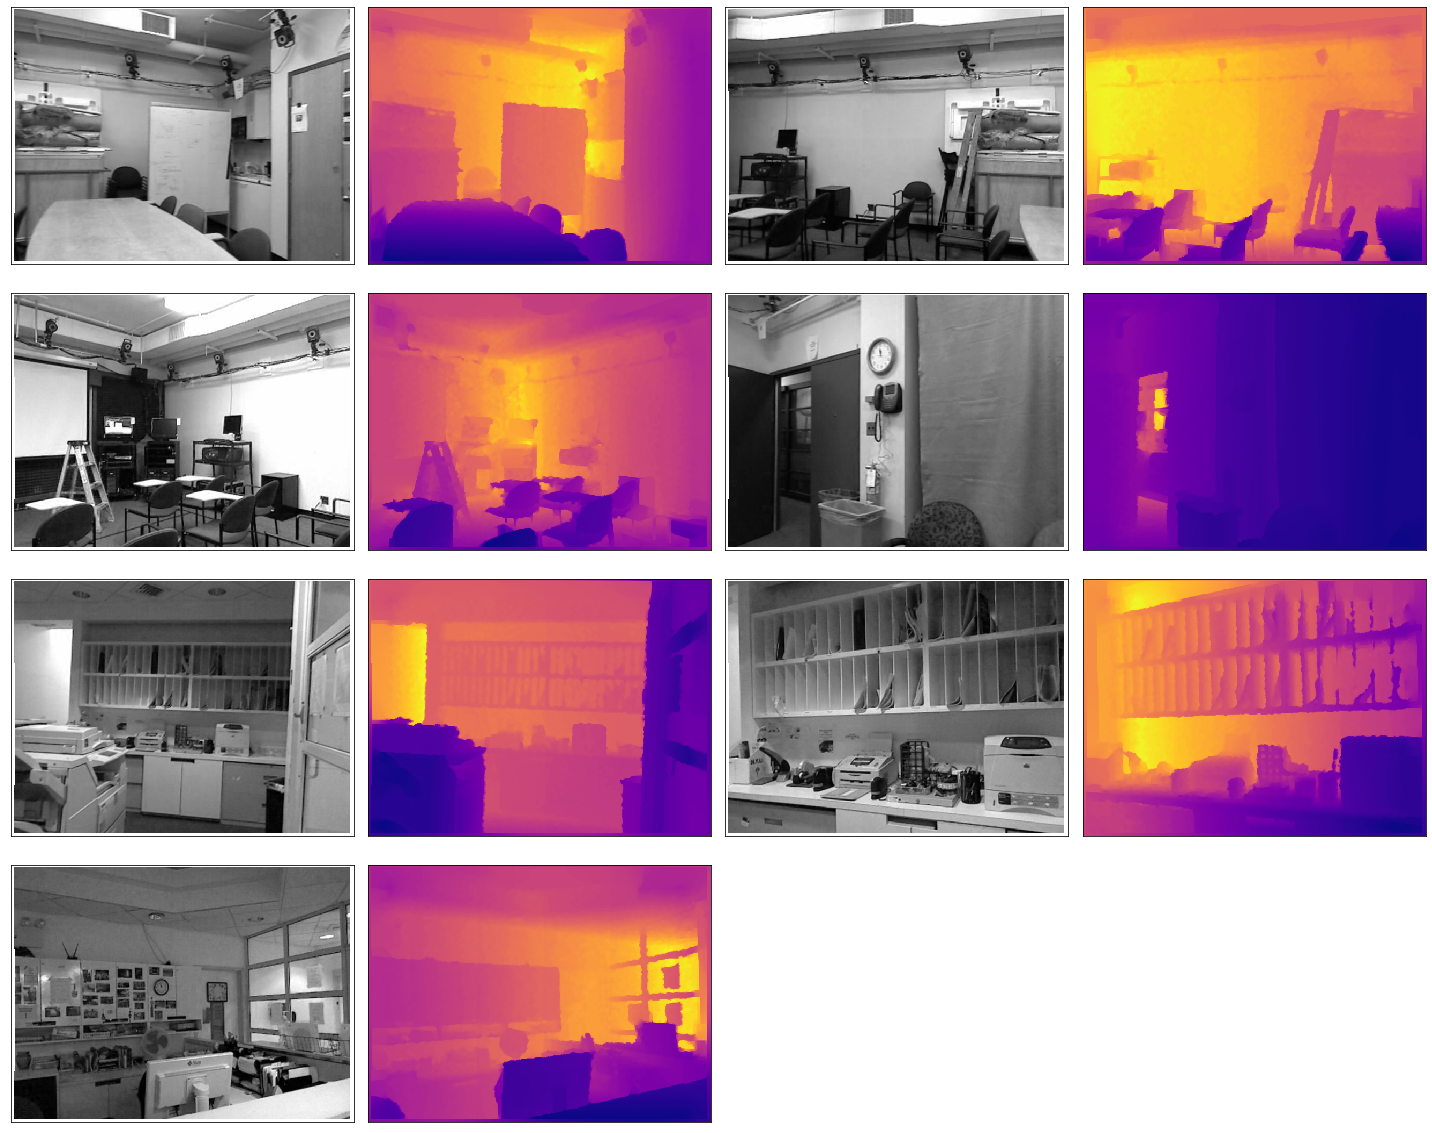

In [ ]:
print(len(images))
fig = plt.figure(figsize=(20,20))
k=1
for sample_idx in range(7):
  print("Data Type: {}, Pre-Transpose: {}".format(type(images[sample_idx]),images[sample_idx].shape))
  plt.subplot(5,4, k)
  plt.imshow(images[train_indices[sample_idx]][0],cmap='gray',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,4, k)
  plt.imshow(depths[train_indices[sample_idx]][0],cmap='plasma',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
fig.tight_layout()
fig.show()

In [ ]:
def get_test_dataset(source_dir, target_dir):
  print("Loading dataset: NYU Depth V2")
  nyud_dict = h5py.File(nyud_file_path, 'r')
  splits_dict = scipy.io.loadmat(splits_file_path)
  return nyud_dict, splits_dict

In [ ]:
test_indices = splits_dict['testNdxs'][:10,0]

In [ ]:
test_images = np.take(images, test_indices, axis=0)
test_images = images.swapaxes(2, 3)

In [ ]:
depths = np.asarray(nyud_dict['depths'], dtype=np.float32)
depths = np.expand_dims(depths.swapaxes(1, 2), 1)
depths = np.take(depths, indices, axis=0)

**Test Data Visualization**

50
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)


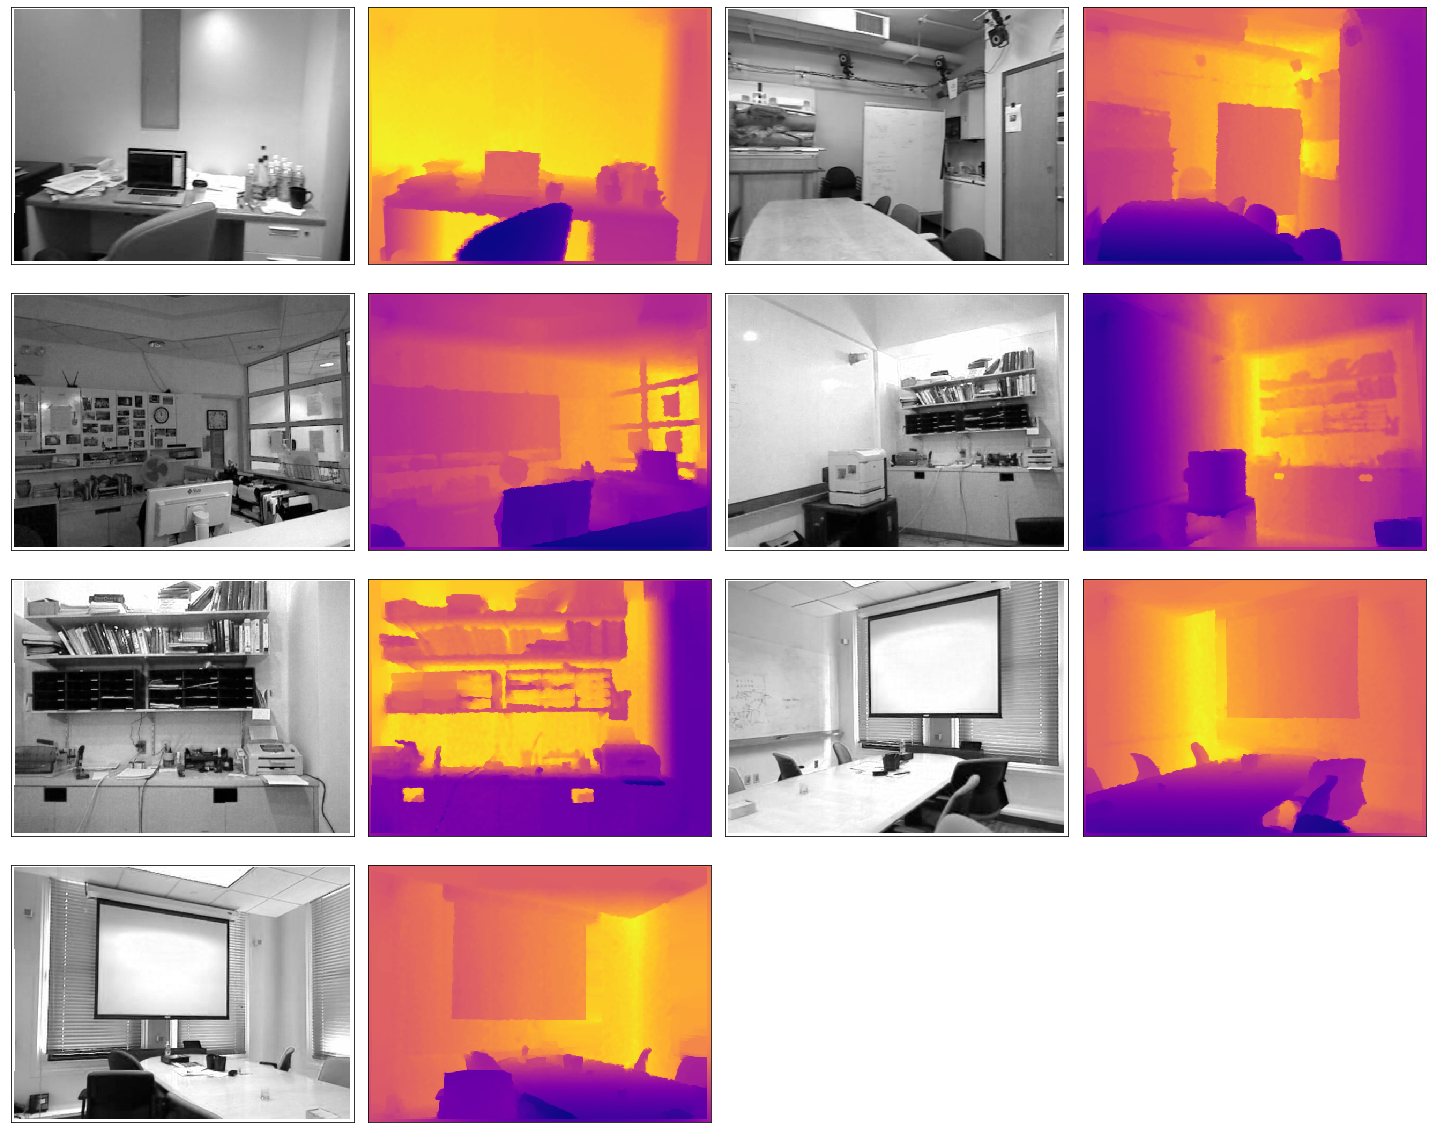

In [ ]:
print(len(test_images))
fig = plt.figure(figsize=(20,20))
k=1
for sample_idx in range(7):
  print("Data Type: {}, Pre-Transpose: {}".format(type(images[sample_idx]),images[sample_idx].shape))
  plt.subplot(5,4, k)
  plt.imshow(test_images[test_indices[sample_idx]][0].transpose(1,0),cmap='gray',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,4, k)
  plt.imshow(depths[test_indices[sample_idx]][0],cmap='plasma',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
fig.tight_layout()
fig.show()